# Stage 2 - Preprocessing


### Import Library and Load Dataset

In [9]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns

# sklearn - model
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [46]:
! gdown 1Ug89rLFlYNGvZHKLORzQmMnZsdSXvgUn

Downloading...
From: https://drive.google.com/uc?id=1Ug89rLFlYNGvZHKLORzQmMnZsdSXvgUn
To: /content/aug_train.csv
100% 1.96M/1.96M [00:00<00:00, 143MB/s]


In [47]:
path = 'aug_train.csv'
df = pd.read_csv(path)
df.sample(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
6507,27324,city_103,0.920,Female,Has relevent experience,NaN,Graduate,STEM,13,NaN,NaN,4,52,1.0
1241,20608,city_21,0.624,NaN,Has relevent experience,Full time course,Masters,STEM,5,NaN,NaN,never,24,1.0
3240,845,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,>4,86,0.0


## 1. Data Cleansing

### A. Handle Missing Value

In [13]:
# Checking missing values
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

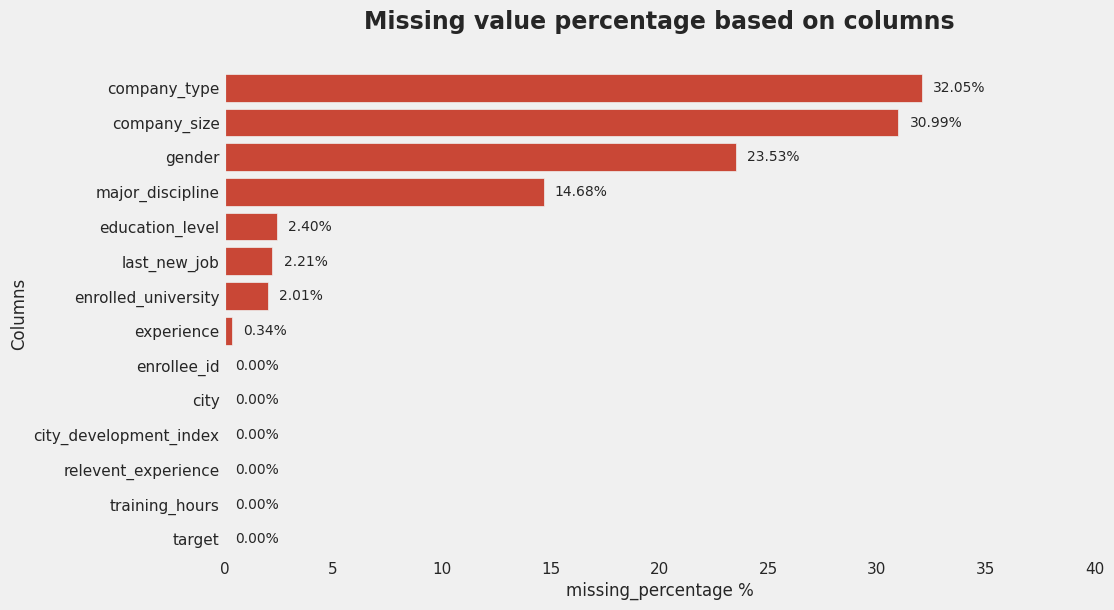

In [14]:
# Plotting missing values each features percentage
missing = df.isnull().sum()*100 / len(df)

percentage_missing = pd.DataFrame({'column':df.columns,
                                   'missing_percentage %':missing.values})
percentage_missing['missing_percentage %'] = percentage_missing['missing_percentage %'].round(2)
percentage_missing = percentage_missing.sort_values('missing_percentage %', ascending=False)
percentage_missing = percentage_missing.reset_index()
percentage_missing = percentage_missing.drop('index', axis=1)

plt.figure(figsize=(10,6))
ax = sns.barplot(x='missing_percentage %', y='column', data=percentage_missing, color='#E1341E')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width() + '%', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(8, 0), textcoords='offset points' ,ha="left", va="center", fontsize=10)
plt.title('Missing value percentage based on columns', fontsize=17, fontweight='bold', pad=30)
plt.ylabel('Columns', fontsize=12)
plt.xlabel('missing_percentage %', fontsize=12)
plt.xlim(0,40)
plt.grid(False)
plt.show()

Handling Missing Values with Imputation Method

In [48]:
#  make a copy of df
dfk = df.copy()

# Identify categorical columns
categorical_columns = dfk.select_dtypes(include=['object']).columns

# Create a SimpleImputer with 'most_frequent strategy
imp_mean = SimpleImputer(strategy='most_frequent')

# fit the imputer on the categorical columns in the dfk dataset
imp_mean.fit(dfk[categorical_columns])

# Impute the missing values in the categorical columns
dfk_imputed_categorical = pd.DataFrame(imp_mean.transform(dfk[categorical_columns]), columns= categorical_columns)

# Combine/concat the imputed categorical columns wiht the original integer columns
dfk = pd.concat([dfk_imputed_categorical, dfk.select_dtypes(exclude=['object'])], axis=1)

In [16]:
dfk.isna().sum()

city                      0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
enrollee_id               0
city_development_index    0
training_hours            0
target                    0
dtype: int64

### B. Handle Duplicated Data

In [17]:
#checking duplicated data for overall dataset
dfk.duplicated().sum()

0

In [18]:
dfk['enrollee_id'].duplicated().sum()

0

'enrollee_id' merupakan feature yang menjadi penanda atau dapat disebut dengan primary key. dengan mengecek kemungkinan duplikasi yang ada pada kolom 'enrollee_id' dapat memastikan ada tidaknya data yang redundant.

### C. Feature Transformation<br>
Mengelompokkan ulang agar kategori menjadi lebih general dan mengurangi unique value.

In [19]:
# there's 1 strange value in company_size feature
dfk.company_size.value_counts()

50-99        9021
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [49]:
# Change problematic column
dfk['company_size'].replace('10/49', '10-49', inplace=True)

In [21]:
dfk.loc[dfk['company_size']=='10-49'].head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,target
15,city_114,Male,Has relevent experience,no_enrollment,Graduate,STEM,16,10-49,Pvt Ltd,>4,6588,0.926,18,0.0
35,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,10,10-49,Early Stage Startup,2,4866,0.920,206,0.0
41,city_104,Male,Has relevent experience,no_enrollment,High School,STEM,4,10-49,Pvt Ltd,2,13854,0.924,36,0.0
49,city_83,Male,Has relevent experience,no_enrollment,Graduate,STEM,11,10-49,Pvt Ltd,1,25103,0.923,21,0.0
58,city_21,Male,Has relevent experience,Full time course,Graduate,STEM,2,10-49,Funded Startup,1,13478,0.624,32,1.0


In [50]:
# city_development_index
conditions_city = [
    (dfk['city_development_index'] > 0.8),
    (dfk['city_development_index'] >= 0.6) & (dfk['city_development_index'] < 0.8),
    (dfk['city_development_index'] < 0.6)
]

choices_city = ['Highly Developed Cities', 'Moderately Developed Cities', 'Less Developed Cities']
dfk['city_category'] = np.select(conditions_city, choices_city, default='Unknown')

# last_new_job
conditions_last_job = [
    (dfk['last_new_job'] == '>4'),
    (dfk['last_new_job'] >= '2') & (dfk['last_new_job'] <= '4'),
    (dfk['last_new_job'].isin(['1', '<1']))
]

choices_last_job = ['High Tenure', 'Medium Tenure', 'Low Tenure']
dfk['last_new_job_category'] = np.select(conditions_last_job,
                                         choices_last_job,
                                         default='Never')

# experience
def categorize_experience(experience):
    if experience in ['10', '11', '12', '13', '14',
                      '15', '16', '17', '18', '19', '20', '>20']:
        return 'Senior Level'
    elif experience in ['4', '5', '6', '7', '8', '9']:
        return 'Intermediate Level'
    elif experience in ['<1', '1', '2', '3']:
        return 'Junior Level'
    return 'Unknown'

dfk['experience_category'] = dfk['experience'].apply(categorize_experience)

# company_size
conditions_company_size = [
    (dfk['company_size'].isin(['<10', '10-49', '50-99'])),
    (dfk['company_size'].isin(['100-500', '500-999'])),
    (dfk['company_size'].isin(['1000-4999', '5000-9999', '10000+']))
]

choices_company_size = ['Small', 'Medium', 'Large']
dfk['company_size_category'] = np.select(conditions_company_size, choices_company_size, default='Unknown')


In [23]:
dfk\
.last_new_job_category\
.value_counts()

Low Tenure       8463
Medium Tenure    4953
High Tenure      3290
Never            2452
Name: last_new_job_category, dtype: int64

In [24]:
dfk.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job', 'enrollee_id', 'city_development_index',
       'training_hours', 'target', 'city_category', 'last_new_job_category',
       'experience_category', 'company_size_category'],
      dtype='object')

In [25]:
new_cat_feature = ['city_category','last_new_job_category',
                   'experience_category', 'company_size_category']
for col in new_cat_feature:
    print(f'''Value Count column {col}:''')
    print(dfk[col].value_counts())
    print()

Value Count column city_category:
Highly Developed Cities        13192
Moderately Developed Cities     5241
Less Developed Cities            725
Name: city_category, dtype: int64

Value Count column last_new_job_category:
Low Tenure       8463
Medium Tenure    4953
High Tenure      3290
Never            2452
Name: last_new_job_category, dtype: int64

Value Count column experience_category:
Senior Level          8747
Intermediate Level    6859
Junior Level          3552
Name: experience_category, dtype: int64

Value Count column company_size_category:
Small     11800
Large      3910
Medium     3448
Name: company_size_category, dtype: int64



Visualization Category Distribution After Feature Transformation

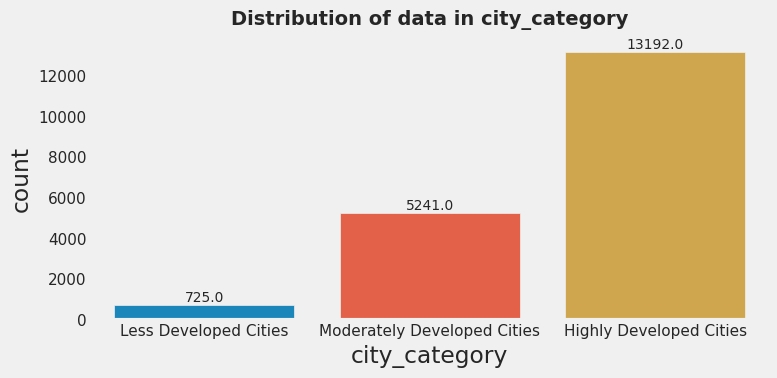

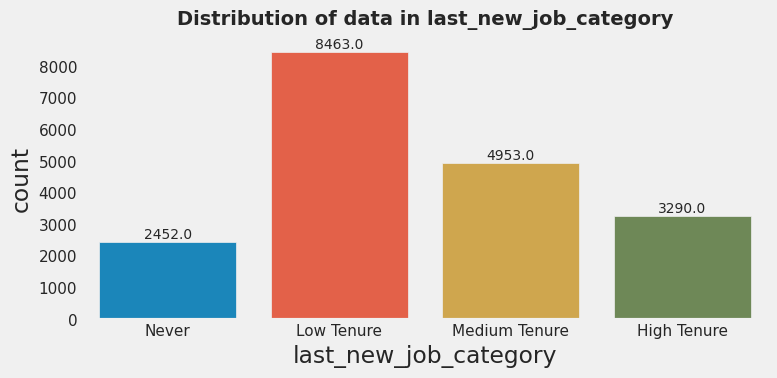

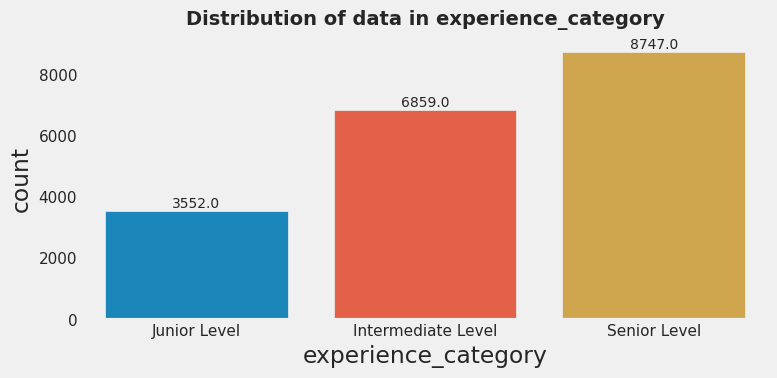

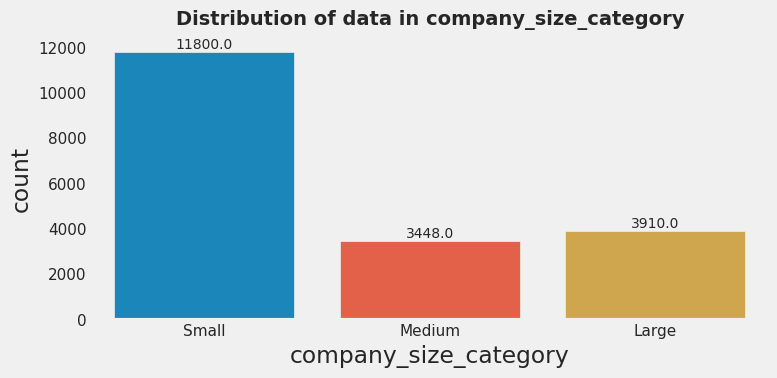

In [26]:
# Define cats_feature for iterative plotting
cats_feature = ['city_category','last_new_job_category', 'experience_category','company_size_category']

# Define custom order for each category
category_order = {
    "city_category": ["Less Developed Cities", "Moderately Developed Cities", "Highly Developed Cities"],
    "last_new_job_category": ["Never", "Low Tenure", "Medium Tenure", "High Tenure" ],
    "experience_category": ["Junior Level", "Intermediate Level", "Senior Level"],
    "company_size_category": ["Small", "Medium", "Large"],
}

# Univariate analysis for categorical features
for feature in cats_feature:  # Make sure 'cats_feature' is defined
    # Create a subplot for each categorical feature
    plt.figure(figsize=(8, 4))

    # Countplot for categorical features with custom order
    sns.countplot(data=dfk, x=feature, order=category_order[feature])
    plt.title(f'Distribution of data in {feature}', size=14, fontweight='bold', pad=10)

    # Add frequency (count) labels to the bars
    ax = plt.gca()  # gets the current axes so that you can draw on it directly
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', size=10)

    plt.grid(False)
    plt.tight_layout()
    plt.show()


Ratio Visualization with the target

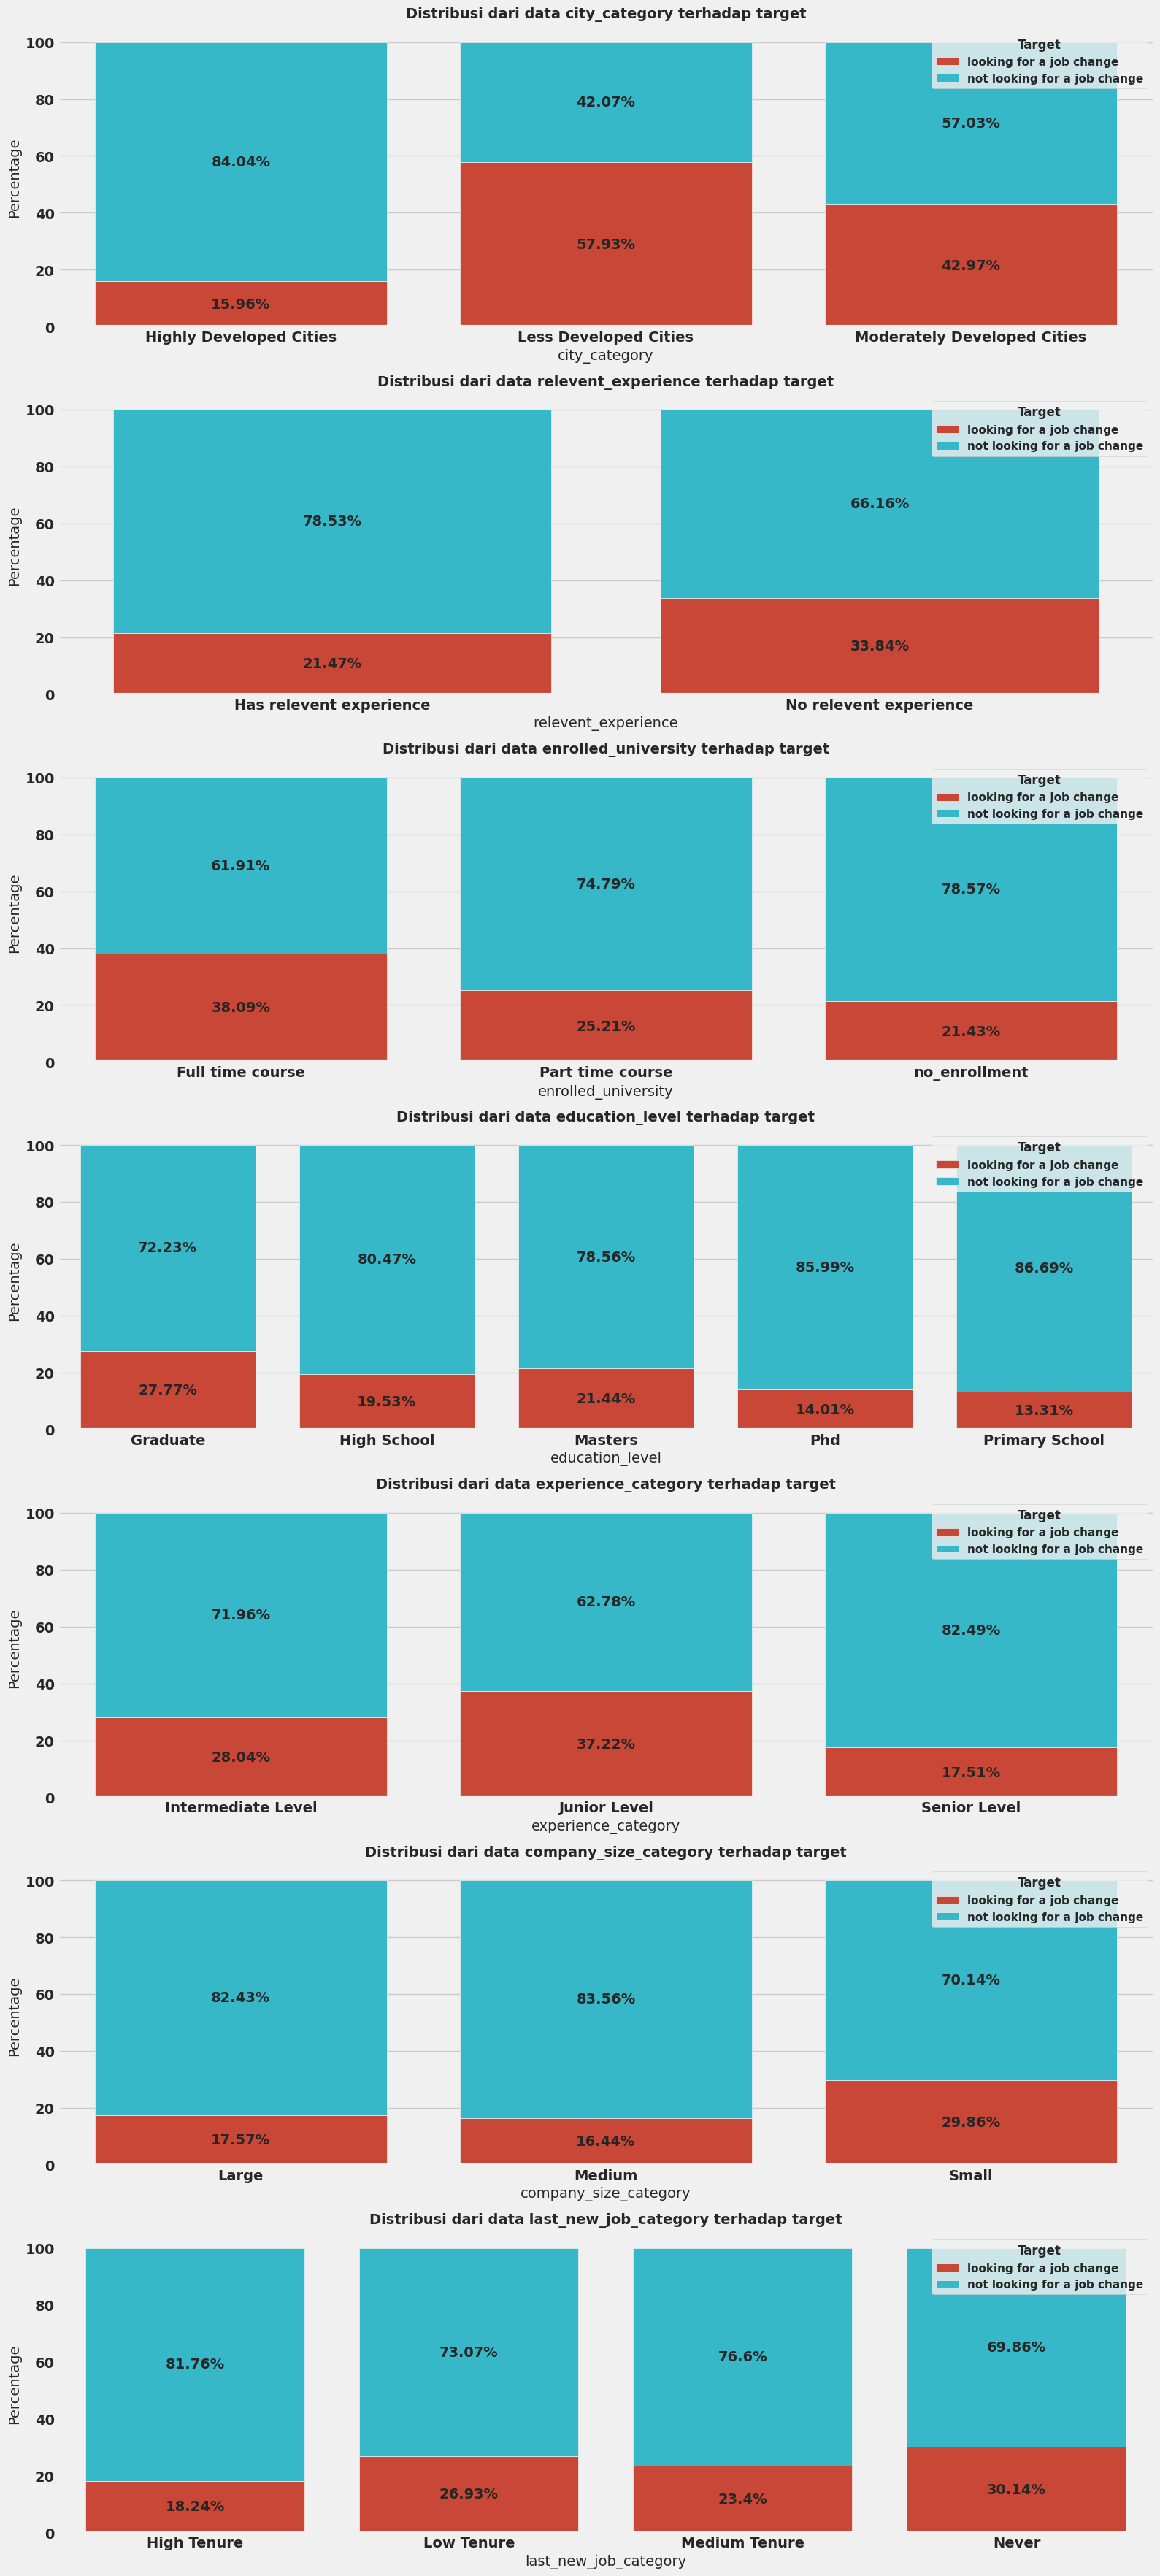

In [85]:
# Memisahkan kolom berdasarkan tipe data
categorical_columns = ['city_category', 'relevent_experience', 'enrolled_university', 'education_level', 'experience_category', 'company_size_category', 'last_new_job_category']
target_column = 'target'

category_order = {
    "city_category": ["Less Developed Cities", "Moderately Developed Cities", "Highly Developed Cities"],
    "last_new_job_category": ["Never", "Low Tenure", "Medium Tenure", "High Tenure" ],
    "experience_category": ["Junior Level", "Intermediate Level", "Senior Level"],
    "company_size_category": ["Small", "Medium", "Large"],
    "education_level": ["Primary School","High School","Graduate","Masters","Phd"]}


plt.figure(figsize=(16, 50))
for i, column in enumerate(categorical_columns):
    plt.subplot(10, 1, i+1)

    # Membuat crosstab antara kolom kategorikal dan kolom target
    crosstab = pd.crosstab(dfk[column], dfk[target_column])
    crosstab_percentage = crosstab.div(crosstab.sum(1), axis=0) * 100  # Menghitung persentase

    # Membuat stacked bar chart
    ax = sns.barplot(x=crosstab_percentage.index, y=crosstab_percentage[1], color='#E1341E', label='looking for a job change')
    ax = sns.barplot(x=crosstab_percentage.index, y=crosstab_percentage[0], color='#1ECBE1', label='not looking for a job change', bottom=crosstab_percentage[1])

    for c in ax.containers:
        labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14) # add a container object "c" as first argument
    # Remove spines
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    # Add labels
    ax.tick_params(labelsize = 14, labelrotation = 0)
    ax.set_ylabel("Percentage", size = 14)
    ax.set_xlabel(column, size = 14)
    # Add legend
    ax.legend(fontsize = 12,
          title = "Target",
          title_fontsize = 18,
          bbox_to_anchor = [0.55, 0.7])


    plt.xticks(rotation=0)
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.title(f'Distribusi dari data {column} terhadap {target_column}', size=14, fontweight='bold', pad=10)
    plt.legend(title='Target', loc='upper right')



plt.grid(False)
plt.tight_layout()
plt.show()

Feature correlation with target after feature transformation

In [28]:
categoric = dfk.select_dtypes('object')
# Create an empty DataFrame to store the chi-square results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'P-Value'])

# Calculate chi-square for each categorical feature
for feature in categoric :
    contingency_table = pd.crosstab(dfk[feature], dfk['target'])
    chi2, p, _, _ = chi2_contingency(contingency_table)


    # Create a temporary DataFrame and concatenate it to the results DataFrame
    temp_df = pd.DataFrame({'Feature' : [feature], 'Chi-Square' : [chi2], 'P-Value' : [p]})
    chi_square_results = pd.concat([chi_square_results, temp_df], ignore_index=True)


# Save the results to a CSV file
chi_square_results.to_csv('chi_square_results.csv', index=False)

# Print the chi square result Ordered by strongest Correlation
chi_squaresult = pd.read_csv('chi_square_results.csv')
chi_squaresult = chi_squaresult.sort_values(by=['Chi-Square'],ascending=False)

# adding correlation column in chi square result
chi_squaresult['Correlation'] = chi_squaresult['P-Value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')
chi_squaresult.to_csv('chi_square_results.csv', index=False)
chi_square_resultsn = pd.read_csv('chi_square_results.csv')
chi_square_resultsn

,Feature,Chi-Square,P-Value,Correlation
0,city,2998.777229,0.000000e+00,Significant
1,city_category,1900.506111,0.000000e+00,Significant
2,experience,690.983270,1.066061e-132,Significant
3,company_size,592.964197,7.971606e-124,Significant
4,experience_category,578.894435,1.970927e-126,Significant
5,enrolled_university,440.458589,2.267945e-96,Significant
6,company_size_category,398.768270,2.561948e-87,Significant
7,relevent_experience,315.338577,1.500663e-70,Significant
8,education_level,160.454092,1.168254e-33,Significant
9,last_new_job,140.620659,1.320494e-28,Significant


## 2. Feature Engineering

### D. Feature Selection
Feature selection based on Chi-Square Correlation and P-Value

In [29]:
dfk.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job', 'enrollee_id', 'city_development_index',
       'training_hours', 'target', 'city_category', 'last_new_job_category',
       'experience_category', 'company_size_category'],
      dtype='object')

In [30]:
# subsetting dfk to dfc
dfc = dfk[[
    # 'city', 'gender'
    'relevent_experience', 'enrolled_university','education_level',
    # 'major_discipline', 'experience', 'company_size',
      'company_type',
    # 'last_new_job', 'enrollee_id',
    #'city_development_index',  'training_hours',
    'target', 'city_category', 'last_new_job_category',
       'experience_category', 'company_size_category'
       ]].copy()

In [31]:
dfc.head(3)

,relevent_experience,enrolled_university,education_level,company_type,target,city_category,last_new_job_category,experience_category,company_size_category
0,Has relevent experience,no_enrollment,Graduate,Pvt Ltd,1.0,Highly Developed Cities,Low Tenure,Senior Level,Small
1,No relevent experience,no_enrollment,Graduate,Pvt Ltd,0.0,Moderately Developed Cities,High Tenure,Senior Level,Small
2,No relevent experience,Full time course,Graduate,Pvt Ltd,0.0,Moderately Developed Cities,Never,Intermediate Level,Small


In [32]:
categoric = dfc.drop(columns='target')
# Create an empty DataFrame to store the chi-square results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'P-Value'])

# Calculate chi-square for each categorical feature
for feature in categoric :
    contingency_table = pd.crosstab(dfc[feature], dfc['target'])
    chi2, p, _, _ = chi2_contingency(contingency_table)


    # Create a temporary DataFrame and concatenate it to the results DataFrame
    temp_df = pd.DataFrame({'Feature' : [feature], 'Chi-Square' : [chi2], 'P-Value' : [p]})
    chi_square_results = pd.concat([chi_square_results, temp_df], ignore_index=True)


# Save the results to a CSV file
chi_square_results.to_csv('chi_square_results.csv', index=False)

# Print the chi square result Ordered by strongest Correlation
chi_squaresult = pd.read_csv('chi_square_results.csv')
chi_squaresult = chi_squaresult.sort_values(by=['Chi-Square'],ascending=False)
chi_squaresult

# adding correlation column in chi square result
chi_squaresult['Correlation'] = chi_squaresult['P-Value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')
chi_squaresult.to_csv('chi_square_results.csv', index=False)
chi_square_resultsn = pd.read_csv('chi_square_results.csv')
chi_square_resultsn

,Feature,Chi-Square,P-Value,Correlation
0,city_category,1900.506111,0.000000e+00,Significant
1,experience_category,578.894435,1.970927e-126,Significant
2,enrolled_university,440.458589,2.267945e-96,Significant
3,company_size_category,398.768270,2.561948e-87,Significant
4,relevent_experience,315.338577,1.500663e-70,Significant
5,education_level,160.454092,1.168254e-33,Significant
6,last_new_job_category,138.540836,7.799560e-30,Significant
7,company_type,91.187945,3.782007e-18,Significant


In [33]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   relevent_experience    19158 non-null  object 
 1   enrolled_university    19158 non-null  object 
 2   education_level        19158 non-null  object 
 3   company_type           19158 non-null  object 
 4   target                 19158 non-null  float64
 5   city_category          19158 non-null  object 
 6   last_new_job_category  19158 non-null  object 
 7   experience_category    19158 non-null  object 
 8   company_size_category  19158 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


### E. Feature engineering - Feature Extraction
Tidak dilakukan karena semua feature berbentuk kategorik

### F. Feature engineering - Feature Encoding


In [34]:
# Print all the feature value counts to Encode the feature Easier
for col in dfc:
    print(f'''Value Count column {col}:''')
    print(dfc[col].value_counts())
    print()

Value Count column relevent_experience:
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64

Value Count column enrolled_university:
no_enrollment       14203
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

Value Count column education_level:
Graduate          12058
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

Value Count column company_type:
Pvt Ltd                15957
Funded Startup          1001
Public Sector            955
Early Stage Startup      603
NGO                      521
Other                    121
Name: company_type, dtype: int64

Value Count column target:
0.0    14381
1.0     4777
Name: target, dtype: int64

Value Count column city_category:
Highly Developed Cities        13192
Moderately Developed Cities     5241
Less Developed Cities            725
Name: city_category, dtype: int64


#### One Hot & Label Encoding

Nominal features to Encode with One Hot Encoding : <br>

*   enrolled_university


In [38]:
# One hot Encoding enrolled university feature
enrolled_encoded = pd.get_dummies(dfc['enrolled_university'], prefix='enrolled')
dfc = pd.concat([dfc, enrolled_encoded], axis=1)

# drop categorical column
dfc.drop(columns=['enrolled_university'], inplace=True)

Ordinal features to Label Encode : <br>

*   education_level
*   city_category
*   last_new_job
*   experience_category
*   company_size_category
*   company_type




In [39]:
# Label Encoding features
# initialize label encoder
label_encoder = LabelEncoder()

# with Sklearn LabelEncoder

dfc['experience_category'] = label_encoder.fit_transform(dfc['experience_category'])
dfc['relevent_experience'] = label_encoder.fit_transform(dfc['relevent_experience'])

# Manual (mapping) label encoding

#encoded feature education_level
mapping_edu = {'Primary School':0,
               'High School':1,
               'Graduate':2,
               'Masters':3,
               'Phd':4
               }
dfc['education_level'] = dfc['education_level'].map(mapping_edu)

#encoded feature city_category
mapping_city_cat = {'Less Developed Cities':0,
                    'Moderately Developed Cities':1,
                    'Highly Developed Cities':2
                    }
dfc['city_category'] = dfc['city_category'].map(mapping_city_cat)

#encoded feature company_size_category
mapping_csize = {'Small':0,
                 'Large':1,
                 'Medium':2
                 }
dfc['company_size_category'] = dfc['company_size_category'].map(mapping_csize)

# encoded feature last_new_job
mapping_new_job = {'Never' : 0,
                   'Low Tenure' : 1,
                   'Medium Tenure' : 2,
                   'High Tenure' : 3}
dfc['last_new_job_category'] = dfc['last_new_job_category'].map(mapping_new_job)

# encode company type based on their funding
mapping_company = {'Other' : 0,
                   'NGO' : 1,
                   'Early Stage Startup' : 2,
                   'Funded Startup' : 3,
                   'Pvt Ltd' : 4,
                   'Public Sector' : 5}
dfc['company_type'] = dfc['company_type'].map(mapping_company)
for col in dfc.columns:
    value_counts = dfc[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")

Value Counts for relevent_experience:
0    13792
1     5366
Name: relevent_experience, dtype: int64

Value Counts for education_level:
2    12058
3     4361
1     2017
4      414
0      308
Name: education_level, dtype: int64

Value Counts for company_type:
4    15957
3     1001
5      955
2      603
1      521
0      121
Name: company_type, dtype: int64

Value Counts for target:
0.0    14381
1.0     4777
Name: target, dtype: int64

Value Counts for city_category:
2    13192
1     5241
0      725
Name: city_category, dtype: int64

Value Counts for last_new_job_category:
1    8463
2    4953
3    3290
0    2452
Name: last_new_job_category, dtype: int64

Value Counts for experience_category:
2    8747
0    6859
1    3552
Name: experience_category, dtype: int64

Value Counts for company_size_category:
0    11800
1     3910
2     3448
Name: company_size_category, dtype: int64

Value Counts for enrolled_Full time course:
0    15401
1     3757
Name: enrolled_Full time course, dtype: int64

Va

### G. Handling Imbalanced Data

#### SMOTE Over Sampling

#### SMOTE - Label and One Hot Encoding
Use SMOTE method to balance the datasets that use label and one hot encoding

In [40]:
# define x and y
x = dfc.drop(columns='target')
y = dfc['target']

#split x y train and x y test
x_trainlab, x_testlab, y_trainlab, y_testlab = train_test_split(x, y, test_size=0.3, random_state=17)

# Initialize SMOTE
smote = SMOTE(random_state=17)

# Doing oversampling to Data Train
x_overlab, y_overlab = smote.fit_resample(x_trainlab, y_trainlab)

In [41]:
x_overlab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20144 entries, 0 to 20143
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   relevent_experience        20144 non-null  int64
 1   education_level            20144 non-null  int64
 2   company_type               20144 non-null  int64
 3   city_category              20144 non-null  int64
 4   last_new_job_category      20144 non-null  int64
 5   experience_category        20144 non-null  int64
 6   company_size_category      20144 non-null  int64
 7   enrolled_Full time course  20144 non-null  uint8
 8   enrolled_Part time course  20144 non-null  uint8
 9   enrolled_no_enrollment     20144 non-null  uint8
dtypes: int64(7), uint8(3)
memory usage: 1.1 MB


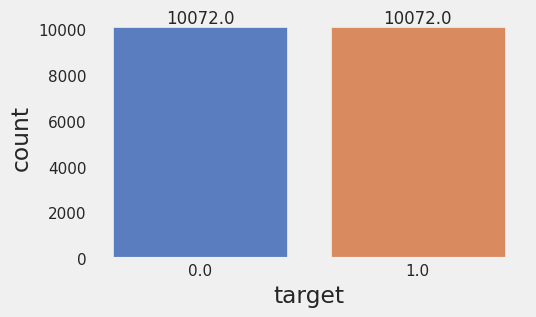

In [42]:
# Set a custom color palette for the countplot
bright_palette = sns.color_palette("muted")

# Create the countplot with the custom color palette
plt.figure(figsize=(5, 3))
ax = sns.countplot(x=y_overlab, data=x_overlab, palette=bright_palette)
sns.despine()

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', size=12)

plt.grid(False)
plt.show()

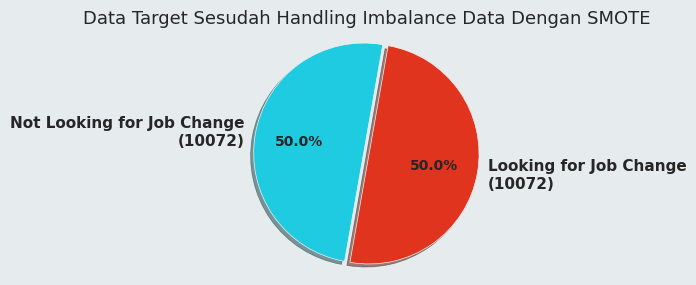

In [43]:
target_counts = y_overlab.value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(6, 3))
fig.patch.set_facecolor('#e6ebed')

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'bold'

wedges, texts, autotexts = ax.pie(target_counts,
                                   explode=(0.05, 0),
                                   labels=['Not Looking for Job Change', 'Looking for Job Change'],
                                   colors=['#1ECBE1', '#E1341E'],
                                   autopct='%1.1f%%',
                                   shadow=True,
                                   startangle=80)

plt.axis('equal')

# Display the total count of each category as text
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({target_counts.iloc[i]})')

plt.title('Data Target Sesudah Handling Imbalance Data Dengan SMOTE', fontsize=13)

plt.show()

# Stage 3 Modelling

In [54]:
x_train = x_overlab
y_train = y_overlab
x_test = x_testlab
y_test = y_testlab

In [55]:
def eval_classification(model) :
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  y_pred_proba = model.predict_proba(x_test)
  y_pred_proba_train = model.predict_proba(x_train)

  print('Confusion matrix data train: ')
  print(confusion_matrix(y_train, y_pred_train))
  print('          ')
  print('Confusion matrix data test: ')
  print(confusion_matrix(y_test, y_pred))
  print('          ')

  print('Accuracy (Train Set): %.2f' % accuracy_score(y_train, y_pred_train))
  print('Accuracy (Test Set): %.2f' % accuracy_score(y_test, y_pred))
  print('Precision (Train Set): %.2f' % precision_score(y_train, y_pred_train))
  print('Precision (Test Set): %.2f' % precision_score(y_test, y_pred))
  print('Recall (Train Set): %.2f' % recall_score(y_train, y_pred_train))
  print('Recall (Test Set): %.2f' % recall_score(y_test, y_pred))
  print('F1-Score (Train Set): %.2f' % f1_score(y_train, y_pred_train))
  print('F1-Score (Test Set): %.2f' % f1_score(y_test, y_pred))

  print('AUC (train-proba): %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
  print('AUC (test-proba): %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))

  score = cross_validate(model, x, y, cv=5, scoring='recall', return_train_score=True)
  print('Recall (crossval train):' + str(score['train_score']))
  print('Recall (crossval train):' + str(score['train_score'].mean()))
  print('Recall (crossval test):' + str(score['test_score']))
  print('Recall (crossval test):' + str(score['test_score'].mean()))

In [56]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

## Fit Model

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
eval_classification(dt)

Confusion matrix data train: 
[[7592 2480]
 [2473 7599]]
          
Confusion matrix data test: 
[[3118 1191]
 [ 565  874]]
          
Accuracy (Train Set): 0.75
Accuracy (Test Set): 0.69
Precision (Train Set): 0.75
Precision (Test Set): 0.42
Recall (Train Set): 0.75
Recall (Test Set): 0.61
F1-Score (Train Set): 0.75
F1-Score (Test Set): 0.50
AUC (train-proba): 0.84
AUC (test-proba): 0.70
Recall (crossval train):[0.37634127 0.3928291  0.36446886 0.39246468 0.35531136]
Recall (crossval train):0.37628305444135257
Recall (crossval test):[0.27615063 0.2876569  0.25445026 0.29005236 0.2565445 ]
Recall (crossval test):0.27297093035992026


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
eval_classification(dt)

Confusion matrix data train: 
[[7592 2480]
 [2473 7599]]
          
Confusion matrix data test: 
[[3116 1193]
 [ 563  876]]
          
Accuracy (Train Set): 0.75
Accuracy (Test Set): 0.69
Precision (Train Set): 0.75
Precision (Test Set): 0.42
Recall (Train Set): 0.75
Recall (Test Set): 0.61
F1-Score (Train Set): 0.75
F1-Score (Test Set): 0.50
AUC (train-proba): 0.84
AUC (test-proba): 0.70
Recall (crossval train):0.37628305444135257
Recall (crossval test):0.2742263795482924


### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
eval_classification(rf)

Confusion matrix data train: 
[[7500 2572]
 [2381 7691]]
          
Confusion matrix data test: 
[[3106 1203]
 [ 541  898]]
          
Accuracy (Train Set): 0.75
Accuracy (Test Set): 0.70
Precision (Train Set): 0.75
Precision (Test Set): 0.43
Recall (Train Set): 0.76
Recall (Test Set): 0.62
F1-Score (Train Set): 0.76
F1-Score (Test Set): 0.51
AUC (train-proba): 0.84
AUC (test-proba): 0.72
Recall (crossval train):0.4074741599174246
Recall (crossval test):0.2968349799557493


### AdaBoost

In [ ]:
ab = AdaBoostClassifier()
ab.fit(x_train, y_train)
eval_classification(ab)

Confusion matrix data train: 
[[7355 2717]
 [3281 6791]]
          
Confusion matrix data test: 
[[3205 1104]
 [ 533  906]]
          
Accuracy (Train Set): 0.70
Accuracy (Test Set): 0.72
Precision (Train Set): 0.71
Precision (Test Set): 0.45
Recall (Train Set): 0.67
Recall (Test Set): 0.63
F1-Score (Train Set): 0.69
F1-Score (Test Set): 0.53
AUC (train-proba): 0.76
AUC (test-proba): 0.74
Recall (crossval train):0.23848590187992738
Recall (crossval test):0.2369659795395299


### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=17)
xgb.fit(x_train, y_train)
eval_classification(xgb)

Confusion matrix data train: 
[[7468 2604]
 [2595 7477]]
          
Confusion matrix data test: 
[[3163 1146]
 [ 524  915]]
          
Accuracy (Train Set): 0.74
Accuracy (Test Set): 0.71
Precision (Train Set): 0.74
Precision (Test Set): 0.44
Recall (Train Set): 0.74
Recall (Test Set): 0.64
F1-Score (Train Set): 0.74
F1-Score (Test Set): 0.52
AUC (train-proba): 0.82
AUC (test-proba): 0.74
Recall (crossval train):0.34770853079822306
Recall (crossval test):0.28448180683037966


### GradientBoosting

In [ ]:
gb = GradientBoostingClassifier(random_state=17)
gb.fit(x_train, y_train)
eval_classification(gb)

Confusion matrix data train: 
[[7173 2899]
 [2845 7227]]
          
Confusion matrix data test: 
[[3116 1193]
 [ 486  953]]
          
Accuracy (Train Set): 0.71
Accuracy (Test Set): 0.71
Precision (Train Set): 0.71
Precision (Test Set): 0.44
Recall (Train Set): 0.72
Recall (Test Set): 0.66
F1-Score (Train Set): 0.72
F1-Score (Test Set): 0.53
AUC (train-proba): 0.78
AUC (test-proba): 0.75
Recall (crossval train):0.2443477211712902
Recall (crossval test):0.23110341957107491


## Hyperparameter Tuning Gradient Boosting

In [ ]:
# List of hyperparameters
learning_rate = [float(x) for x in np.linspace(0.01, 0.04, 50)]
n_estimators = [int(x) for x in np.linspace(1, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 10, 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, 10)]
max_depth = [int(x) for x in np.linspace(1, 10, 10)]
max_leaf_nodes = [int(x) for x in np.linspace(1,10,10)]
n_iter_no_change = [int(x) for x in np.linspace(1,10,10)]

hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators,
                       min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                       max_depth=max_depth,max_leaf_nodes=max_leaf_nodes, n_iter_no_change=n_iter_no_change)

# Crossvalidate with GridSearch
gb = GradientBoostingClassifier()
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=17)
gb_tune = RandomizedSearchCV(gb, hyperparameters, scoring='recall', cv=stratified_kfold)
gb_tune.fit(x_train, y_train)
eval_classification(gb_tune)

Confusion matrix data train: 
[[6984 3088]
 [2768 7304]]
          
Confusion matrix data test: 
[[3030 1279]
 [ 462  977]]
          
Accuracy (Train Set): 0.71
Accuracy (Test Set): 0.70
Precision (Train Set): 0.70
Precision (Test Set): 0.43
Recall (Train Set): 0.73
Recall (Test Set): 0.68
F1-Score (Train Set): 0.71
F1-Score (Test Set): 0.53
AUC (train-proba): 0.77
AUC (test-proba): 0.75
Recall (crossval train):0.14899414962973495
Recall (crossval test):0.14255931126640234


### Learning Curve

param value: 0.0001; train : 0.7372355695071735; test : 0.7196357285710806
param value: 0.0013224489795918366; train : 0.7433805482574707; test : 0.7252813454587268
param value: 0.002544897959183673; train : 0.7435209837068263; test : 0.7254344745414634
param value: 0.0037673469387755096; train : 0.7453933347885692; test : 0.7281929752214726
param value: 0.004989795918367347; train : 0.7481009744139258; test : 0.7308418099970471
param value: 0.006212244897959183; train : 0.7499188132972385; test : 0.732407129509466
param value: 0.00743469387755102; train : 0.7503280589446216; test : 0.7334843551104553
param value: 0.008657142857142856; train : 0.7504946809500587; test : 0.7339152776055289
param value: 0.009879591836734692; train : 0.7518708231629803; test : 0.7355694587552177
param value: 0.011102040816326528; train : 0.7538509664490332; test : 0.7373552389902286
param value: 0.012324489795918365; train : 0.753945845275415; test : 0.7372781503103465
param value: 0.013546938775510203; t

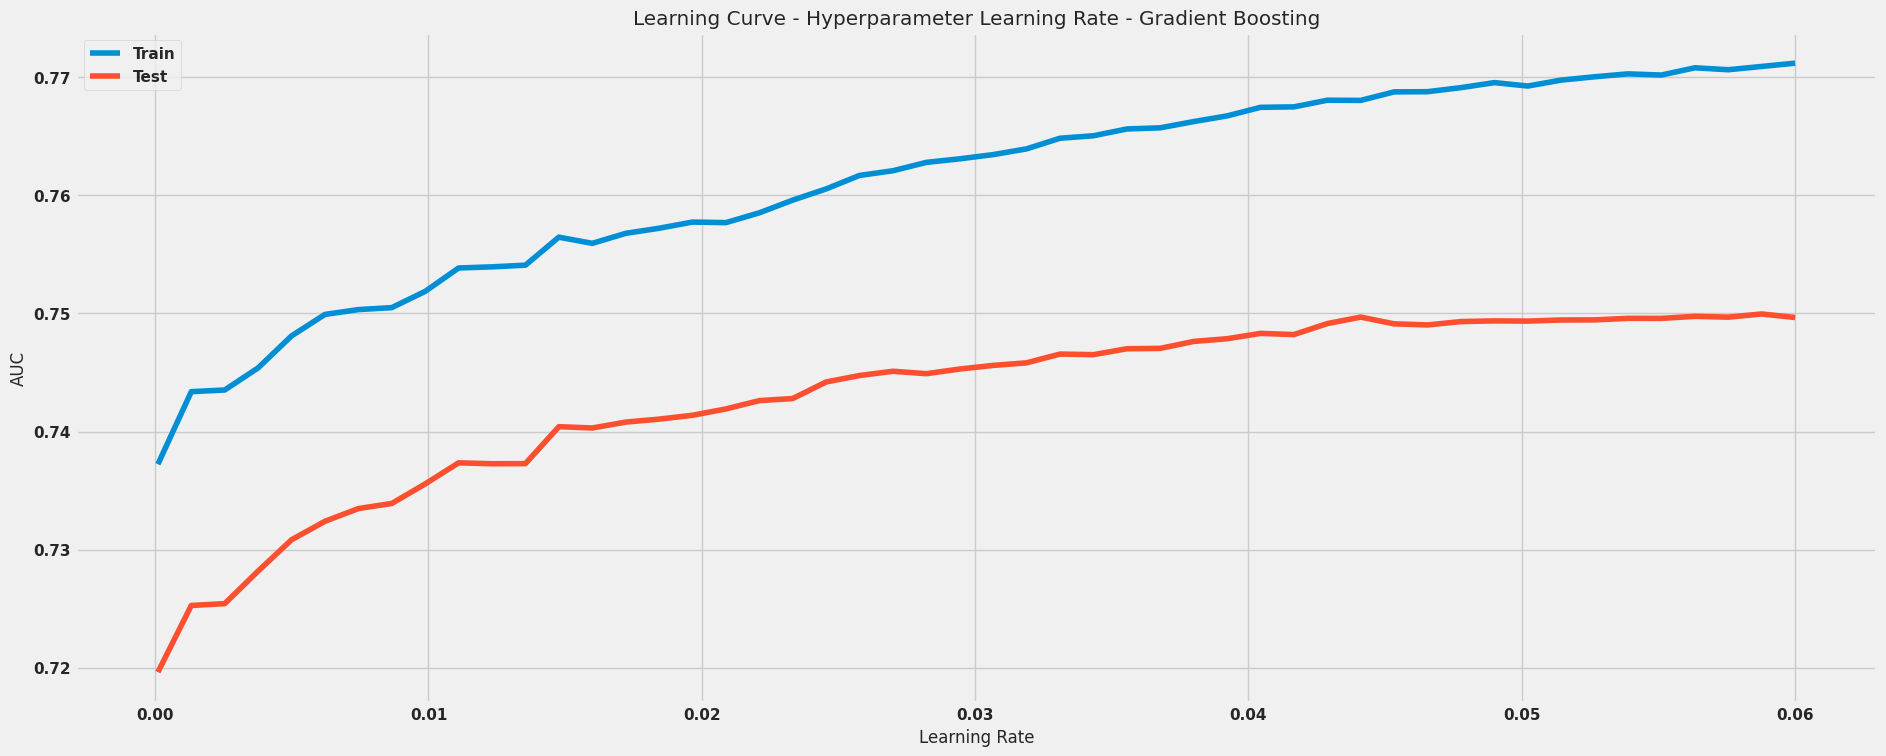

In [ ]:
def draw_learning_curve(param_values):
  train_scores = []
  test_scores = []

  for lr in param_values:
    gbc = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=lr)
    gbc.fit(x_train, y_train)

    # eval on train
    y_pred_train_proba = gbc.predict_proba(x_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # eval on test
    y_pred_proba = gbc.predict_proba(x_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(lr) + '; train : ' + str(train_auc) + '; test : ' + str(test_auc))

  plt.plot(param_values, train_scores, label='Train')
  plt.plot(param_values, test_scores, label = 'Test')
  plt.xlabel('Learning Rate')
  plt.ylabel('AUC')
  plt.title('Learning Curve - Hyperparameter Learning Rate - Gradient Boosting')
  plt.legend()
  plt.show()

param_values = [float(x) for x in np.linspace(0.0001, 0.06, 50)]
draw_learning_curve(param_values)

param value: 1; train : 0.7372355695071735; test : 0.7196357285710806
param value: 3; train : 0.743525035155932; test : 0.7254381838294075
param value: 5; train : 0.7440651741535605; test : 0.7257945173821265
param value: 7; train : 0.7499372912567244; test : 0.7324323687948249
param value: 9; train : 0.7508766409256056; test : 0.7339439036320541
param value: 11; train : 0.7533174615760959; test : 0.7362207613361886
param value: 13; train : 0.7548968662721336; test : 0.7376531915761749
param value: 15; train : 0.7558600021860081; test : 0.7397590188514077
param value: 17; train : 0.7563247408570918; test : 0.7402538862451702
param value: 19; train : 0.7568288751883973; test : 0.740134221390625
param value: 21; train : 0.7580059985893464; test : 0.7404666864817904
param value: 23; train : 0.7591519031598386; test : 0.7406354590832479
param value: 25; train : 0.760986411143973; test : 0.7420439402249861
param value: 27; train : 0.7626612910475868; test : 0.7442890270715123
param value: 2

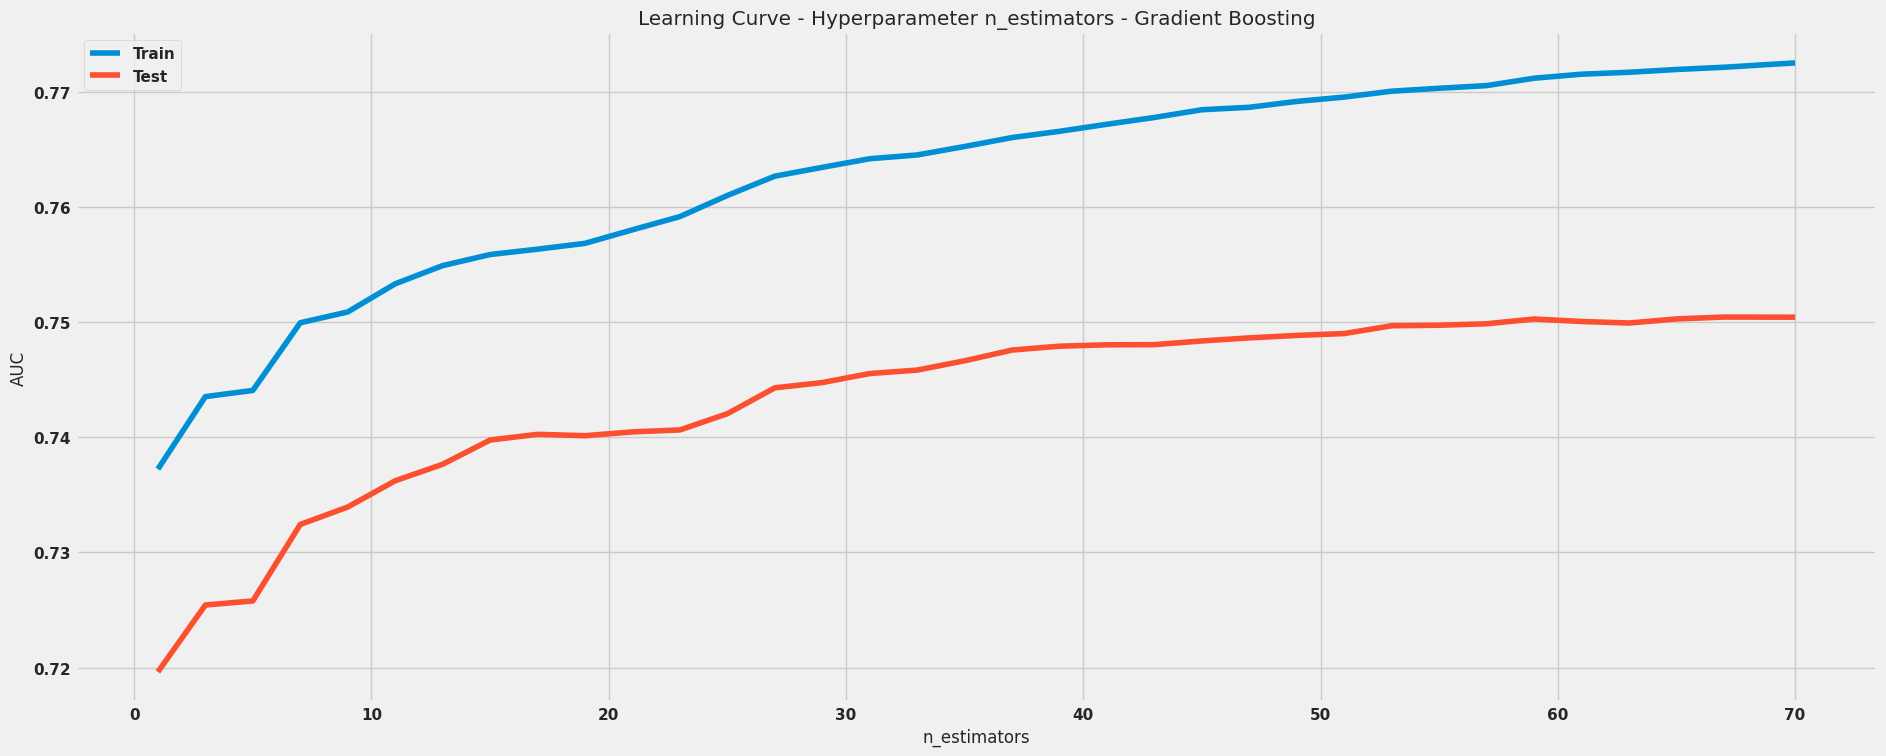

In [ ]:
def draw_learning_curve(param_values):
  train_scores = []
  test_scores = []

  for es in param_values:
    gbc = GradientBoostingClassifier(criterion='friedman_mse', n_estimators=es)
    gbc.fit(x_train, y_train)

    # eval on train
    y_pred_train_proba = gbc.predict_proba(x_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # eval on test
    y_pred_proba = gbc.predict_proba(x_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(es) + '; train : ' + str(train_auc) + '; test : ' + str(test_auc))

  plt.plot(param_values, train_scores, label='Train')
  plt.plot(param_values, test_scores, label = 'Test')
  plt.xlabel('n_estimators')
  plt.ylabel('AUC')
  plt.title('Learning Curve - Hyperparameter n_estimators - Gradient Boosting')
  plt.legend()
  plt.show()

param_values = [int(x) for x in np.linspace(1, 70, 35)]
draw_learning_curve(param_values)

In [ ]:
show_best_hyperparameter(gb_tune)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.02292929292929293, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 17, 'n_iter_no_change': 9, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [ ]:
gb_tuned = GradientBoostingClassifier(learning_rate = 0.018, n_estimators=17,
                                      min_samples_split=5, min_samples_leaf=2, max_leaf_nodes=6,
                                      max_depth=3, n_iter_no_change=9, random_state=17)
gb_tuned.fit(x_train, y_train)
eval_classification(gb_tuned)

Confusion matrix data train: 
[[6556 3516]
 [2662 7410]]
          
Confusion matrix data test: 
[[2826 1483]
 [ 442  997]]
          
Accuracy (Train Set): 0.69
Accuracy (Test Set): 0.67
Precision (Train Set): 0.68
Precision (Test Set): 0.40
Recall (Train Set): 0.74
Recall (Test Set): 0.69
F1-Score (Train Set): 0.71
F1-Score (Test Set): 0.51
AUC (train-proba): 0.74
AUC (test-proba): 0.73
Recall (crossval train):[0. 0. 0. 0. 0.]
Recall (crossval train):0.0
Recall (crossval test):[0. 0. 0. 0. 0.]
Recall (crossval test):0.0


### Feature Importance

In [ ]:
# Melatih model dengan hyperparameter yang disesuaikan
gb_tuned = GradientBoostingClassifier(learning_rate=0.02292929292929293, n_estimators=17,
                                      min_samples_split=5, min_samples_leaf=2, max_leaf_nodes=6,
                                      max_depth=3, n_iter_no_change=9, random_state=17)
gb_tuned.fit(x_train, y_train)

# Mendapatkan kepentingan fitur dari model yang telah dilatih
feature_importance = gb_tuned.feature_importances_

# Mendapatkan nama fitur dari data latih
feature_names = x_train.columns

# Membuat DataFrame untuk menampilkan kepentingan fitur
feature_importance_df = pd.DataFrame(
    {'Fitur': feature_names, 'Kepentingan': feature_importance}
)

# Mengurutkan kepentingan fitur secara menurun
feature_importance_df = feature_importance_df.sort_values(by='Kepentingan', ascending=False)

# Menampilkan hasil
print(feature_importance_df)


                       Fitur  Kepentingan
3              city_category     0.719338
6      company_size_category     0.169954
0        relevent_experience     0.045853
2               company_type     0.026218
5        experience_category     0.026212
7  enrolled_Full time course     0.007991
4      last_new_job_category     0.003378
1            education_level     0.001057
8  enrolled_Part time course     0.000000
9     enrolled_no_enrollment     0.000000


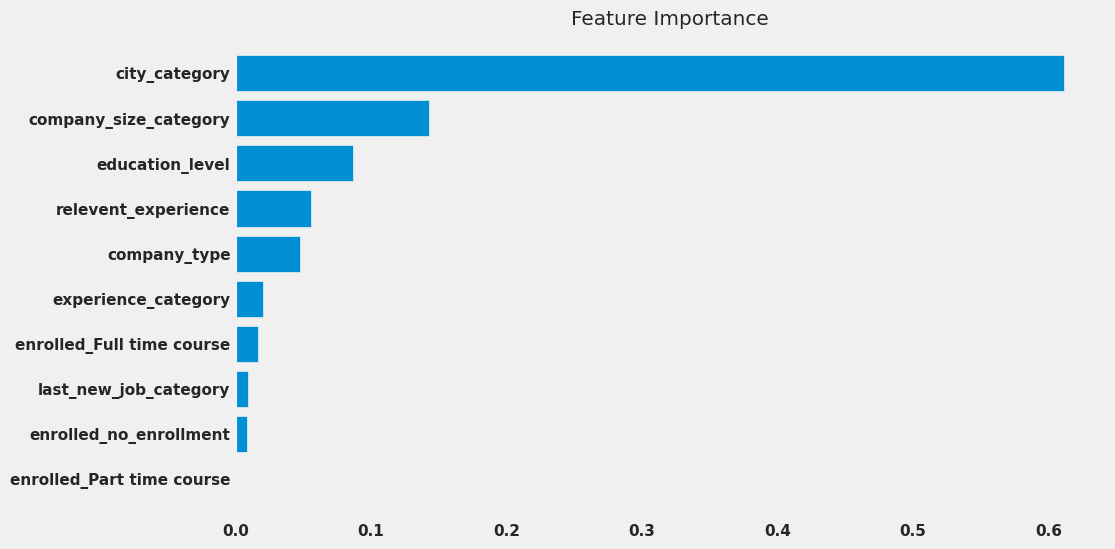

In [ ]:
def plot_feature_importances(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.barh(range(x_train.shape[1]), importances[indices])

    # Add feature names as y-axis labels
    plt.yticks(range(x_train.shape[1]), names)

    # Invert y-axis to have the feature with the highest importance at the top
    plt.gca().invert_yaxis()

    # Show plot
    plt.grid(False)
    plt.show()

# Call the function with your best estimator and feature names
plot_feature_importances(gb_tune.best_estimator_, x_train.columns)

### Business Insight

Business Insights:

City Category (0.719338):

Insight: Kategori kota memiliki dampak besar pada keputusan karyawan untuk berhenti setelah pelatihan.

Company Size Category (0.169954):

Insight: Ukuran perusahaan juga memiliki pengaruh, meskipun tidak sebesar kategori kota.

Relevant Experience (0.045853):

Insight: Pengalaman yang relevan tampaknya memainkan peran yang cukup signifikan.

Company Type (0.026218):

Insight: Jenis perusahaan memiliki pengaruh, meskipun relatif kecil.

Experience Category (0.026212):

Insight: Kategori pengalaman karyawan juga memberikan kontribusi pada keputusan untuk berhenti.

Enrolled Full-Time Course (0.007991):

Insight: Pendaftaran penuh waktu memiliki dampak, meskipun kecil.

Last New Job Category (0.003378):

Insight: Kategori pekerjaan terakhir juga mempengaruhi keputusan karyawan untuk berhenti.

Education Level (0.001057):

Insight: Tingkat pendidikan memiliki dampak minimal pada keputusan untuk berhenti.

### Business Action

Action Business Items:

City Category (0.719338):

Action: Melakukan analisis lebih lanjut terkait faktor-faktor spesifik di kategori kota tertentu yang mungkin mempengaruhi keputusan tersebut. Mungkin perlu dilakukan survei atau wawancara untuk mendapatkan pemahaman yang lebih baik.

Company Size Category (0.169954):

Action: Menganalisis perbedaan antara perusahaan-perusahaan berukuran besar dan kecil untuk memahami faktor-faktor apa yang mungkin memengaruhi keputusan karyawan.

Relevant Experience (0.045853):

Action: Fokus pada peningkatan pelatihan yang berhubungan langsung dengan pekerjaan atau menyesuaikan program pelatihan dengan kebutuhan spesifik karyawan.

Company Type (0.026218):

Action: Menganalisis perbedaan antara jenis perusahaan dan melihat apakah ada aspek tertentu yang dapat ditingkatkan dalam pelatihan untuk setiap jenis perusahaan.

Experience Category (0.026212):

Action: Menyesuaikan program pelatihan untuk memenuhi kebutuhan karyawan berdasarkan kategori pengalaman mereka.

Enrolled Full-Time Course (0.007991):

Action: Memastikan bahwa program pelatihan penuh waktu memenuhi harapan karyawan dan memberikan nilai tambah yang cukup untuk mereka.

Last New Job Category (0.003378):

Action: Menilai apakah ada pola tertentu dalam jenis pekerjaan terakhir yang membuat karyawan lebih mungkin untuk mencari pekerjaan baru setelah pelatihan.

Education Level (0.001057):

Action: Fokus pada aspek-aspek lain yang mungkin lebih mempengaruhi keputusan karyawan, karena tingkat pendidikan tampaknya bukan faktor penentu utama.